# 6.4 Cary Machine Learning: Regression

## Contents:

01. Install Libraries
02. Import Libraries
03. Import Datasets
04. Clean Data for Analysis
05. Explore Data & Hypothesize
       - Explore data visually using scatterplots
       - State hypothesis
06. Prep for linear regression
       - Reshape variables into Numpy Arrays
       - Split data into training & test sets
07. Run Linear Regression
       - Fit model on training set
       - Create prediction for y on test set
       - Create a plot showing regression line on test set
       - Check model performance statistics
       - Compare predicted with actual y values
08. Export Datasets

# 01. Install Libraries

In [188]:
pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set 

# 02. Import Libraries

In [673]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import geopandas as gpd
from shapely.geometry import Point
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 03. Import Datasets

In [9]:
# Defines path as intro file path for Cary Real Estate project

path = r'/home/0668a905-109d-4403-be59-0a04abf51dd9/Cary Real Estate Analysis'

In [12]:
# Imports cary_cleaned / wrangled dataset

df = pd.read_parquet(os.path.join(path, '01 Datasets', '02 Prepared Data', 'cary_cleaned_wrangled.parquet'))

In [249]:
# Import Geo shape file

import geopandas as gpd

file_path = "/home/0668a905-109d-4403-be59-0a04abf51dd9/Cary Real Estate Analysis/01 Datasets/01 Original Data/tl_2024_us_zcta520.shp"

try:
    zcta_gdf = gpd.read_file(file_path)
    print("File loaded successfully")
    print(type(zcta_gdf))
    print(zcta_gdf.head())
except Exception as e:
    print(f"An error occurred: {e}")


File loaded successfully
<class 'geopandas.geodataframe.GeoDataFrame'>
  ZCTA5CE20 GEOID20       GEOIDFQ20 CLASSFP20 MTFCC20 FUNCSTAT20  ALAND20  \
0     47236   47236  860Z200US47236        B5   G6350          S  1029063   
1     47870   47870  860Z200US47870        B5   G6350          S     8830   
2     47851   47851  860Z200US47851        B5   G6350          S    53326   
3     47337   47337  860Z200US47337        B5   G6350          S   303089   
4     47435   47435  860Z200US47435        B5   G6350          S    13302   

   AWATER20   INTPTLAT20    INTPTLON20  \
0         0  +39.1517426  -085.7252769   
1         0  +39.3701518  -087.4735141   
2         0  +39.5735839  -087.2459559   
3         0  +39.8027537  -085.4372850   
4         0  +39.2657557  -086.2951577   

                                            geometry  
0  POLYGON ((-85.7341 39.15597, -85.72794 39.1561...  
1  POLYGON ((-87.47414 39.37016, -87.47409 39.370...  
2  POLYGON ((-87.24769 39.5745, -87.24711 39.574

In [231]:
print(zcta_gdf)

/home/0668a905-109d-4403-be59-0a04abf51dd9/Cary Real Estate Analysis/01 Datasets/01 Original Data/tl_2024_us_zcta520.shp


In [321]:
# Set the display option to show all columns

pd.set_option('display.max_columns', None)

# 04. Clean Data for Analysis

### 1. Group landclass into large sub categories (to maintain at min 5,000 observations)

From previous tasks, it was clear that landclass categories would need to be grouped into larger, more meaningful groups. One reason being that observations will need to be larger than 5000 for a regression test. The other is that the current classes are a bit too refined and specific (there's over 200 classes), so a larger grouping might provide more helpful insights.

After grouping, missing & extreme values will be checked by category.

In [90]:
df.shape

(291937, 23)

In [298]:
# Check for missing values

df.isna().sum()

location                0
deedacres               0
landclass           13466
totalstructures     74392
totalunits          74392
propertydesc           24
bldgvalue               0
landvalue               0
landsalevalue       13373
landsaledate       204664
totalsalevalue          0
totalsaledate       74889
county                  0
totalbldgsqft       49476
phycity             13559
phyzip              15848
shape_starea            0
shape_stlength          0
yearbuilt           99173
geo_shape               0
geo_point_2d            0
latitude                0
longitude               0
dtype: int64

#### Need to Remove Missing Landclass Rows 

(13,373 is only 4.6% of the entire dataset, so will remove for easier classification within analysis)

In [107]:
# Create new dataframe & drop rows where 'landclass' is NA

df_2 = df.dropna(subset=['landclass'])

In [116]:
# Confirm if landclass rows are all null

df_2['landclass'].isna().sum()

0

In [119]:
# Check 'landclass' categories

df_2['landclass'].unique()

array(['Res  1 Family', 'Res Twnh W  Land', 'Com  Office Condo',
       'Vac Res  Homeowners', 'Vacant Commercial', 'Vac Res  Lot Sml Tra',
       'Res  Condominium', 'Cmnty Svc  Police Fi', 'Wild Parks Fdrl Proj',
       'Com  Drive In Bank', 'Res  2 Family', 'Com  Auto Car Wash',
       'Vac Res  Developer', 'Vacant Land (Undiff)',
       'Com  Apt Garden S42', 'Com  Multi Use Condo',
       'Unk Leasehold Condo', 'Vacant Industrial', 'Community Svcs (Undi',
       'Vac Com  W  Leasehol', 'Com  Fast Food', 'Vacres Lt Smltr Side',
       'Com  Parking Lots Su', 'Com  Whse Storage', 'Com  Office Bldg',
       'Publ Svc  Railroads', 'Ind  Misc Research',
       'Vacant Community Ser', 'Publ Svc  Elec Trans',
       'Vac Res  < 10 Acres', 'Com  Retail Services',
       'Vac Res  Rural < 10', 'Present Use Agricult',
       'Com  Auto Body Tire', 'Vacant Private Utili',
       'Cmnty Svc  Library', 'Vac Res  W  Sml Impr',
       'Ind  Microelectronic', 'Com  Banks & Offices',
       'Publ 

In [174]:
df_2.shape

(278471, 24)

#### Create Landclass Grouping Column

In [265]:
# Create a Flag that groups together 'landclass' variables by their commonalities

def land_group(row):
    if row['landclass'] in ['Residential Less Than 10 Acres', 'Acres Greater Than 10 With House', 'Manufactured Home', 'Res  Residential (Un', 'Res  Mobile Home', 'Res  3 Family', 'Res  Estate', 'Res  Dwg + 1 Mbl Hm', 'Res  2 Mh Or Mh Site', 'Res  Dwg + 2 Mbl Hms', 'Res  4 Family', 'Res  Historical', 'Res  1 Family', 'Res Twnh W  Land', 'Res  Condominium', 'Res  2 Family', 'Res Twnh W  Lnd S4', 'Res  1 Mh Or Mh Site', "Res  Multiple Dwg'S", 'Res  Homeowners Asso', 'Res  Rural Residenti', 'Res  Lshld Improv']:
        return 'Residential'
    elif row['landclass'] in ['Commercial', 'Com  Homeowners Asso', 'Com  1 Sty Sm Multi', 'Com  Lumber Yrds Saw', 'Com  Salvage Yard', 'Com  Misc Services', 'Com  W  Leasehold', 'Com  Bank W  Office', 'Com  Standard Bank', 'Com  Snack Bars', 'Com  Dwntwn Row Atta', 'Com  Living Accomm', 'Com  Trucking Termin', 'Com  Ret Svs Leaseho', 'Com  Inns B&B Rm Hou', 'Com  Leasehold W  Ac', 'Com  Motel', 'Com  Historical', 'Com  Bank & Office L', 'Com  Dwntwn Row Deta', 'Com  Self Ser Car Wa', 'Com  Manual Car Wash', 'Com  Night Clubs', 'Com  Lrg Retail Food', 'Com  Bar', 'Com Dlrship Sls&Svc', 'Com Prking Garage De', 'Com  Dining Establis', 'Com  Office Condo', 'Com  Drive In Bank', 'Com  Auto Car Wash', 'Com  Apt Garden S42', 'Com  Multi Use Condo', 'Com  Fast Food', 'Com  Parking Lots Su', 'Com  Whse Storage', 'Com  Office Bldg', 'Com  Retail Services', 'Com  Auto Body Tire', 'Com  Banks & Offices', 'Com  Dining Leasehol', 'Com  Apt Garden', 'Com  Commercial (Und', 'Com  Svc & Gas Stati', 'Com  Motor Vehicle S', 'Com  Mobile Home Par', 'Com  Funeral Home', 'Com Conv Store W O G', 'Com  Conv Store W  G', 'Com  Professional Bl', 'Com  Area Shop Ctrs', 'Com  Regional Shop C', 'Com  Restaurants', 'Com  Hotel', 'Com  Mini Warehouses', 'Com Auto Dlr Sls&Svc', 'Com  Converted Resid', 'Com  1 Sty Sm Sgl Us', 'C0M  Lrg Retail Outl', 'Com  Diners & Lunch', 'Com  Vet Clinic', 'Com  Multi Use Capab']:
        return 'Commercial'
    elif row['landclass'] in ['Industrial', 'Ind  Biotech   Bioph', 'Ind  Info Tech   Tel', 'Ind  Environmental S', 'Ind  Lshld Improv', 'Ind  Industrial (Und', 'Ind Pharmaceutical H', 'Ind  W  Leasehold', 'Ind  Misc Research', 'Ind  Microelectronic', 'Ind  Manuf Processin']:
        return 'Industrial'
    elif row['landclass'] in ['Vac Res  Underwater', 'Vacant', 'Vac Com  Developer', 'Vac Prv Utl  Sewage', 'Vac Developer Utilit', 'Vac Conservation Eas', 'Vac Ag  W  Non Lvg I', 'Vac Ag  Other Rural', 'Vac Res  Homeowners', 'Vacant Commercial', 'Vac Res  Lot Sml Tra', 'Vac Res  Developer', 'Vacant Land (Undiff)', 'Vacant Industrial', 'Vac Com  W  Leasehol', 'Vacres Lt Smltr Side', 'Vacant Community Ser', 'Vac Res  < 10 Acres', 'Vac Res  Rural < 10', 'Vacant Private Utili', 'Vac Res  W  Sml Impr', 'Vacres Lt Smltr Rear', 'Vac Com  Condo Assoc', 'Vac Comm Svc  Grvl P', 'Vac Ag  10 Acres Or']:
        return 'Vacant'
    elif row['landclass'] in ['Cmnty Svc  College', 'Cmnty Svc  Govt Hwy', 'Cmnty Svc  Otr Edu F', 'Cmnty Svc  Welfare', 'Cmnty Svc  Misc', 'Cmnty Svc Dclt Ld&I', 'Cmnty Svc  Rcrtnl Fa', 'Cmnty Svc Hme Fr Agd', 'Cmnty Svc Edu Prk Lt', 'Cmnty Svc  Church Sc', 'Cmnty Svc  Gov Pub P', 'Cmnty Svc  Rds Str P', 'Cmnty Svc Cemtery Ta', 'Cmnty Svc  Govt Bldg', 'Cmnty Svc  Health', 'Cmnty Svc  Gov Prk G', 'Cmnty Svc  Other Hlt', 'Cmnty Svc  Abc Store', 'Cmnty Svc  Special S', 'Cmnty Svc  Correctio', 'Cmnty Svs Asst Lvgs4', 'Cmnty Svc  W  Leaseh', 'Cmnty Svc  Prof Asso', 'Cmnty Svc  Govt Lshl', 'Cmnty Svc  Hospital', 'Cmnty Svc  Police Fi', 'Community Svcs (Undi', 'Cmnty Svc  Library', 'Cmnty Svc Cemtery Ex', 'Cmnty Svc  School', 'Cmnty Svc Church Prk', 'Cmnty Svc  Church', 'Cmnty Svc  Child Day', 'Cmnty Svc  Bnvlnt As', 'Cmnty Svc  Religious', 'Cmnty Svs Asstd Lvg', 'Cmnty Svc Church Prs', 'Cmnty Svc  Education', 'Cmnty Svc  Cultural']:
        return 'Community Service'
    elif row['landclass'] in ['Apartment', 'Mobile Home Park', 'Condominium', 'Com Apt High Ri', 'Retirement Home', 'Com Apt Dwg Con', 'Condo Complex']:
        return 'Multi-Family Residential'
    elif row['landclass'] in ['Agriculture', 'Horticulture', 'Ag  Year Round', 'Present Use Agricult', 'Present Use Forestry', 'Ag  1 Family', 'Present Use Horticul']:
        return 'Agriculture'
    elif row['landclass'] in ['Golf Course', 'Rec  Other Misc', 'Rec  Athletic Fields', 'Rec  Outdoor Spt Lsh', 'Rec  Golf Course', 'Rec  Outdoor Swimmin', 'Rec  Ymca Or Ywca', 'Rec  Motion Pic Thea', 'Rec  Parks', 'Rec  Bowling', 'Rec  Tv & Radio Stud', 'Rec  Social Organiza', 'Rec  Indoor Spt Faci', 'Rec  Entrtn Amuse(Un', 'Rec  Country Club', 'Rec  Outdoor Sport A']:
        return 'Recreation'
    elif row['landclass'] in ['Water/Sewer System', 'Publ Svc  Gas Transm', 'Publ Svc  Water Supp', 'Publ Svc  Water', 'Publ Svc  Waste Disp', 'Publ Svc  Railroads', 'Publ Svc  Elec Trans', 'Publ Svc  Sewer & Wa', 'Publ Svc  Transporta', 'Publ Svc  Telephone']:
        return 'Public Service'
    elif row['landclass'] in ['Exempt', 'Hoa', 'Part Exempt', 'Historic', 'Forestry', 'Cemetery', 'Acre With Improvement, No House', 'State Assessed', 'Wild Parks State Pro', 'Wild Parks Fdrl Proj', 'Unk Leasehold Condo']:
        return 'Miscellaneous'
    else:
        return 'Other'

# Apply the function to create the new column
df_2['landgroup'] = df_2.apply(land_group, axis=1)


/tmp/ipykernel_177/3412284645.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['landgroup'] = df_2.apply(land_group, axis=1)


In [268]:
# Check the counts for each group within 'landgroup'

df_2['landgroup'].value_counts()

landgroup
Residential                 234996
Vacant                       19773
Miscellaneous                13717
Commercial                    5484
Multi-Family Residential      1382
Industrial                    1099
Agriculture                    899
Community Service              631
Public Service                 413
Recreation                      77
Name: count, dtype: int64

### 2. Ensure no missing data (e.g. Zip Codes)

#### A. Use ZCTA .shp files to find missing zip codes

In [200]:
# There are 2474 missing zip codes. This information might be found using the ZCTA shape files.

df_2.isna().sum()

location                0
deedacres               0
landclass               0
totalstructures     61019
totalunits          61019
propertydesc           21
bldgvalue               0
landvalue               0
landsalevalue           0
landsaledate       191198
totalsalevalue          0
totalsaledate       61423
county                  0
totalbldgsqft       36010
phycity               186
phyzip               2474
shape_starea            0
shape_stlength          0
yearbuilt           85707
geo_shape               0
geo_point_2d            0
latitude                0
longitude               0
landgroup               0
dtype: int64

In [219]:
# Convert ZIP codes to strings 

df_2['phyzip'] = df_2['phyzip'].astype(str).str.zfill(5)

/tmp/ipykernel_177/1768146854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['phyzip'] = df_2['phyzip'].astype(str).str.zfill(5)


In [252]:
# Create a geo dataframe

gdf_properties = gpd.GeoDataFrame(
    df_2, 
    geometry=gpd.points_from_xy(df_2.longitude, df_2.latitude),
    crs="EPSG:4326"
)

In [255]:
# Perform a spacial join

joined_gdf = gpd.sjoin(gdf_properties, zcta_gdf, how="left", predicate="within")

/tmp/ipykernel_177/2598967121.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(gdf_properties, zcta_gdf, how="left", predicate="within")


In [258]:
# Update missing zip codes

df_2.loc[df_2['phyzip'].isnull(), 'phyzip'] = joined_gdf.loc[df_2['phyzip'].isnull(), 'ZCTA5CE20']

In [281]:
# Checking for missing zip codes after the above - yay no more missing!

df_2['phyzip'].isna().sum()

0

#### B. Check Aggregates as Additional Way to Verify Missing Data (e.g. "$0" values)

In [476]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [479]:
# Check aggregate values (min, max, mean, median, std dev) of numerical columns for any extreme values

residential_stats = df_2[df_2['landgroup'] == 'Residential']['totalsalevalue'].agg(['min', 'max', 'median', 'mean', 'std'])
residential_stats

min               0.00
max      12,003,000.00
median      292,937.00
mean        331,678.32
std         233,943.64
Name: totalsalevalue, dtype: float64

In [574]:
residential = df_2[(df_2['landgroup'] == 'Residential') & (df_2['totalsalevalue'] < 40000)]
residential.shape

(13306, 25)

##### Notes on Missing $0 Values in TotalSaleValue

1. After exploring the different sale value columns, a new column called 'calcvalue' will be created to be either by 1) the totalsalevalue amount, 2) the sum of the land and the building value if the totalsalevalue amount is $0, or 3) the sum of bldgvalue and landvalue if this amount is higher than the totatsalevalue (when not $0). The reason for this, is that we want the best estimate of property value. Assuming that land and buildings are appraised by legal entities or home insurance companies, etc, there must be a reason for the land and building values, and those should not be devalued by a lower total sale value (though there could be more of a story here).

2. There might still be some inaccurate values in totalsalevalue as it might be equal to only the land value or the building value if there is an empty value for either. So later on, it may be necessary to remove the rows that don't provide a solid total calculated value of the property. However, this could also be dependent on the landclass type--for example, a mobile home would only be valued for it's building, not necessarily the land. 

In [556]:
# Use the numpy "where" function to create rules around new column "calcvalue"

import numpy as np

df_2['calcvalue'] = np.where(df_2['totalsalevalue'] > 0,
                             np.where((df_2['bldgvalue'] + df_2['landvalue']) > df_2['totalsalevalue'],
                                      df_2['bldgvalue'] + df_2['landvalue'],
                                      df_2['totalsalevalue']),
                             df_2['bldgvalue'] + df_2['landvalue'])

/tmp/ipykernel_177/230829196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['calcvalue'] = np.where(df_2['totalsalevalue'] > 0,


In [559]:
residential = df_2[(df_2['landgroup'] == 'Residential') & (df_2['calcvalue'] == 0)]
residential.shape

(0, 25)

In [562]:
# Check aggregate values (min, max, mean, median, std dev) of numerical columns for any extreme values

residential_stats = df_2[df_2['landgroup'] == 'Residential']['calcvalue'].agg(['min', 'max', 'median', 'mean', 'std'])
residential_stats

min               1.00
max      12,003,000.00
median      476,294.00
mean        531,864.03
std         308,626.70
Name: calcvalue, dtype: float64

In [571]:
residential_2 = df_2[(df_2['landgroup'] == 'Residential') & (df_2['calcvalue'] < 40000)]
residential_2.shape

(207, 25)

##### "calcvalue" Notes:

This might be a better approach for the analysis as we have a lot fewer rows below $40,000 (from 13306 to 207). Although the std deviation when up by around 100,000 which is interesting. 


There are also no more $0 for our total calculated property value which is great!

Will leave the $1 outliers for now since they are smaller in number, and will proceed with the analysis.

#### C. Check deedacres for "0" Values 

In [631]:
# Check aggregate values (min, max, mean, median, std dev) of numerical columns for any extreme values

deedacres_stats = df_2[df_2['landgroup'] == 'Residential']['deedacres'].agg(['min', 'max', 'median', 'mean', 'std'])
deedacres_stats

min        0.00
max      195.97
median     0.23
mean       0.40
std        1.13
Name: deedacres, dtype: float64

In [634]:
deedacres_stats = df_2[(df_2['landgroup'] == 'Residential') & (df_2['deedacres'] == 0)]
deedacres_stats.shape

(1571, 25)

##### Notes:

Will leave these 0 acres in case this could indicate that the property is for the building only (like a mobile home)

### 3. Check for Duplicate Rows

In [535]:
# Checks for duplicate rows - 3 duplicate rows detected

dups = df_2.duplicated()
dups.sum()

0

In [324]:
df_2[df_2.duplicated()]

,location,deedacres,landclass,totalstructures,totalunits,propertydesc,bldgvalue,landvalue,landsalevalue,landsaledate,totalsalevalue,totalsaledate,county,totalbldgsqft,phycity,phyzip,shape_starea,shape_stlength,yearbuilt,geo_shape,geo_point_2d,latitude,longitude,landgroup
228530,5015 Southpark Dr,0.0,Vac Com Condo Assoc,NaN,NaN,SOUTHPARK OFFICE CONDOS/B LDG 1/COMMON SPACE P...,0,1,1,NaT,1,NaT,Durham,<NA>,Durham,27713,193654.5611,1823.332932,NaT,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00...",b'\x01\x01\x00\x00\x00\xe8\x00?DT\xbcS\xc0B\xd...,35.912495,-78.942643,Vacant
267988,5015 Southpark Dr,0.0,Vac Com Condo Assoc,NaN,NaN,SOUTHPARK OFFICE CONDOS/B LDG 1/COMMON SPACE P...,0,1,1,NaT,1,NaT,Durham,<NA>,Durham,27713,193654.5611,1823.332932,NaT,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00...",b'\x01\x01\x00\x00\x00\xe8\x00?DT\xbcS\xc0B\xd...,35.912495,-78.942643,Vacant
268141,5015 Southpark Dr,0.0,Vac Com Condo Assoc,NaN,NaN,SOUTHPARK OFFICE CONDOS/B LDG 1/COMMON SPACE P...,0,1,1,NaT,1,NaT,Durham,<NA>,Durham,27713,193654.5611,1823.332932,NaT,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00...",b'\x01\x01\x00\x00\x00\xe8\x00?DT\xbcS\xc0B\xd...,35.912495,-78.942643,Vacant


In [328]:
# Drop duplicate rows

df_2 = df_2.drop_duplicates()

In [334]:
# Duplicate rows eliminated

df_2[df_2.duplicated()]

,location,deedacres,landclass,totalstructures,totalunits,propertydesc,bldgvalue,landvalue,landsalevalue,landsaledate,totalsalevalue,totalsaledate,county,totalbldgsqft,phycity,phyzip,shape_starea,shape_stlength,yearbuilt,geo_shape,geo_point_2d,latitude,longitude,landgroup


### 4. Extreme Values Check

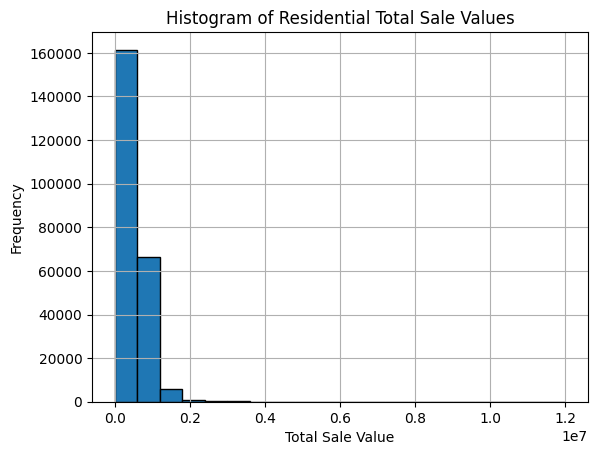

In [578]:
# Filter the DataFrame for 'Res  2 Family'
hist_1 = df_2[df_2['landgroup'] == 'Residential']

# Create the histogram
hist_1['calcvalue'].hist(bins=20, edgecolor='black')

# Customize the plot
plt.title('Histogram of Residential Total Sale Values')
plt.xlabel('Total Sale Value')
plt.ylabel('Frequency')

# Display the plot
plt.show()

# 05. Explore Data & Hypothesize

### 1. Explore data visually using scatterplots

In [699]:
# Simplify the data being extracted for analysis by making a subset dataframe "res_value"

res_value = df_2[df_2['landgroup'] == 'Residential'][['deedacres', 'calcvalue']]
res_value.shape

(234996, 2)

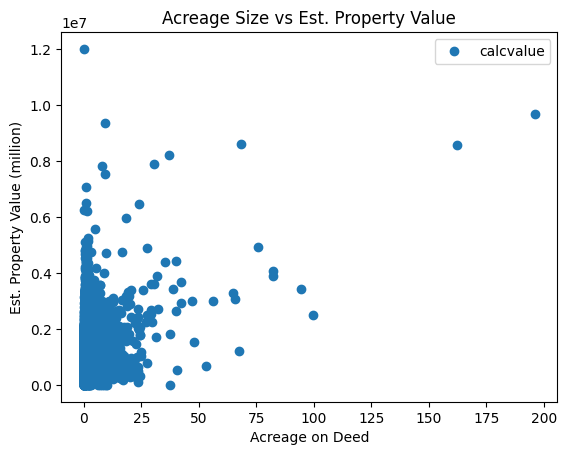

In [696]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.

res_value.plot(x = 'deedacres', y='calcvalue',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Acreage Size vs Est. Property Value')  
plt.xlabel('Acreage on Deed')  
plt.ylabel('Est. Property Value (million)')  
plt.show()

### 2. State Hypothesis

If the acreage size of the property increase, the estimated property value will also increase.

# 06. Prep for Linear Regression

### 1. Reshape variables into NumPy arrays

In [705]:
# Reshape the variables into NumPy arrays and put them into separate objects.

X = res_value['deedacres'].values.reshape(-1,1)
y = res_value['calcvalue'].values.reshape(-1,1)

In [709]:
X

array([[0.15],
       [0.16],
       [0.22],
       ...,
       [0.64],
       [0.07],
       [0.09]])

In [712]:
y

array([[235414],
       [220192],
       [351648],
       ...,
       [82896],
       [291123],
       [160865]], dtype=object)

### 2. Split data into training & test sets

In [717]:
# Split data into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 07. Run Linear Regression

### 1. Fit model on training set

In [722]:
# Create a regression object.

regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [726]:
# Fit the regression object onto the training set.

regression.fit(X_train, y_train)

LinearRegression()

### 2. Create prediction for y on test set

In [731]:
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

### 3. Create a plot showing regression line on test set

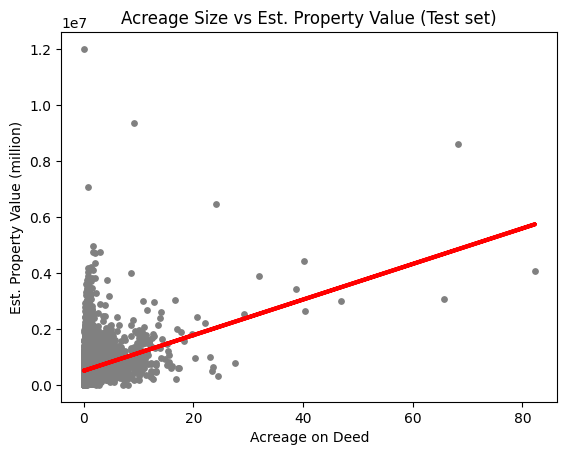

In [735]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Acreage Size vs Est. Property Value (Test set)')
plot_test.xlabel('Acreage on Deed')
plot_test.ylabel('Est. Property Value (million)')
plot_test.show()

#### Interpretation Notes:

At first glance, you see a slightly upward slope, so we know there's somewhat of a correlation, though it's not a strong one. We need to validate further with the MSE, R2, & Y predicted values to better understand the model performance.

### 4. Check model performance statistics

#### MSE Score & R2 Score

In [740]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [745]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[63580.99663623]]
Mean squared error:  88578293796.30373
R2 score:  0.058812969645524626


#### Y Predicted

In [753]:
y_predicted

array([[520358.40084258],
       [529259.74037165],
       [526080.69053984],
       ...,
       [512092.87127987],
       [511457.06131351],
       [509549.63141442]])

In [761]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,1021209,"520,358.40"
1,821100,"529,259.74"
2,178665,"526,080.69"
3,449000,"517,179.35"
4,1329930,"634,168.38"
5,320276,"509,549.63"
6,498520,"521,630.02"
7,705689,"524,173.26"
8,63420,"553,420.52"
9,172899,"507,006.39"


### 5. Compare predicted w/ actual y values

In [769]:
# Predict.

y_predicted_train = regression.predict(X_train) # This is predicting X_train!

In [773]:
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [777]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[63580.99663623]]
Mean squared error:  90043291954.08092
R2 score:  0.059462624380393736


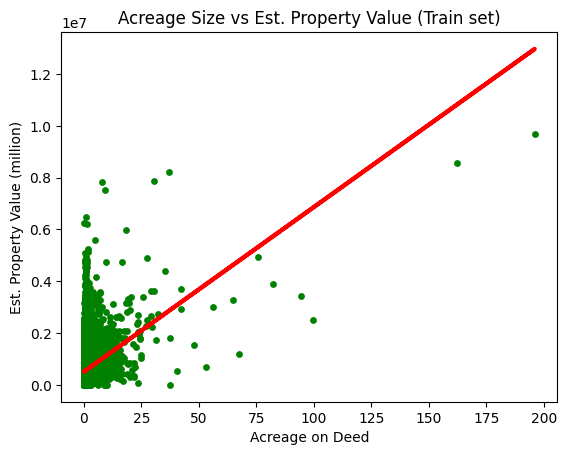

In [784]:
# Visualizing the training set results.

plot_test = plt
plot_test.scatter(X_train, y_train, color='green', s = 15)
plot_test.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_test.title('Acreage Size vs Est. Property Value (Train set)')
plot_test.xlabel('Acreage on Deed')
plot_test.ylabel('Est. Property Value (million)')
plot_test.show()

#### Model Performance Notes:

1. Slope:
   - Both test and train sets have the same slope: 63580.99663623
   - This indicates consistency in the relationship between the independent and dependent variables across both sets.

2. R-squared (R2) score:
   - Test set: 0.0588 (5.88%)
   - Train set: 0.0595 (5.95%)
   - These low R2 values suggest that the model explains only about 6% of the variability in the data, which is quite low (on a scale from 0 - 1; 1 being a perfect fit).

3. Mean Squared Error (MSE):
   - Test set: 88,578,293,796
   - Train set: 90,043,291,954
   - The MSE values are quite large, indicating significant prediction errors.

##### Potential Issues:
- Non-linear relationship: the data might have a non-linear relationship that a linear model can't capture.
- Missing variables: There might be other factors influencing the dependent variable that aren't included in the model (e.g. mobile home where price of land isn't accounted for or perhaps other factors such as the types of residential land classes grouped together within the "residential" group).
- Outliers or high variability: the data contains outliers that's already known (missing acreage, $1 property value, etc) that is not helping with this low model performance.

- Explore your data visually to understand the relationship between variables.
- Consider non-linear models or adding polynomial terms.
- Look for other relevant features that could improve the model.
- Check for and possibly remove outliers.

Bottom line is that only 6% R2 is a poor indication of a correlation and does not support the hypothesis with the variables in their current state.

# 08. Export Datasets

In [805]:
#### Export cleaned df_2 data into the Prepared Data folder

df_2.to_parquet(os.path.join(path, '01 Datasets','02 Prepared Data', 'cary_grouped.parquet'), compression = 'snappy')